# Sienna\Ops Production Cost Modeling Demo using the [PowerSimulations.jl](https://github.com/nrel-sienna/powersimulations.jl) package
**Cambodia Example**: from [PowNet](https://github.com/kamal0013/PowNet)

https://github.com/NREL-Sienna/PSI-Cambodia

In [1]:
import Pkg
Pkg.status()

Status `~/Documents/Projects/DFAT-P4I-NextGenESP/Training-Materials/collab-sienna-julia/MY-Training/PSI-Cambodia-example-2025-06-30/Project.toml`
  [336ed68f] CSV v0.10.15
⌅ [a93c6f00] DataFrames v1.6.1
  [87dc4568] HiGHS v1.18.1
  [98b081ad] Literate v2.20.1
  [f0f68f2c] PlotlyJS v0.18.16
⌅ [56ce1300] PowerAnalytics v0.3.3
⌃ [5f7eddb3] PowerGraphics v0.14.0
⌅ [e690365d] PowerSimulations v0.20.2 ⚲
⌅ [bcd98974] PowerSystems v2.6.1
  [ade2ca70] Dates v1.11.0
  [56ddb016] Logging v1.11.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


## Introduction
This example shows how to run a PCM study using Powersimulations.jl. This example depends upon a
dataset of the Cambodian grid assembled using the
[Cambodia-data-prep.jl](./Cambodia-data-prep.jl) script and [PowerSystems.jl](https://github.com/nrel-sienna/powersystems.jl).

<!-- 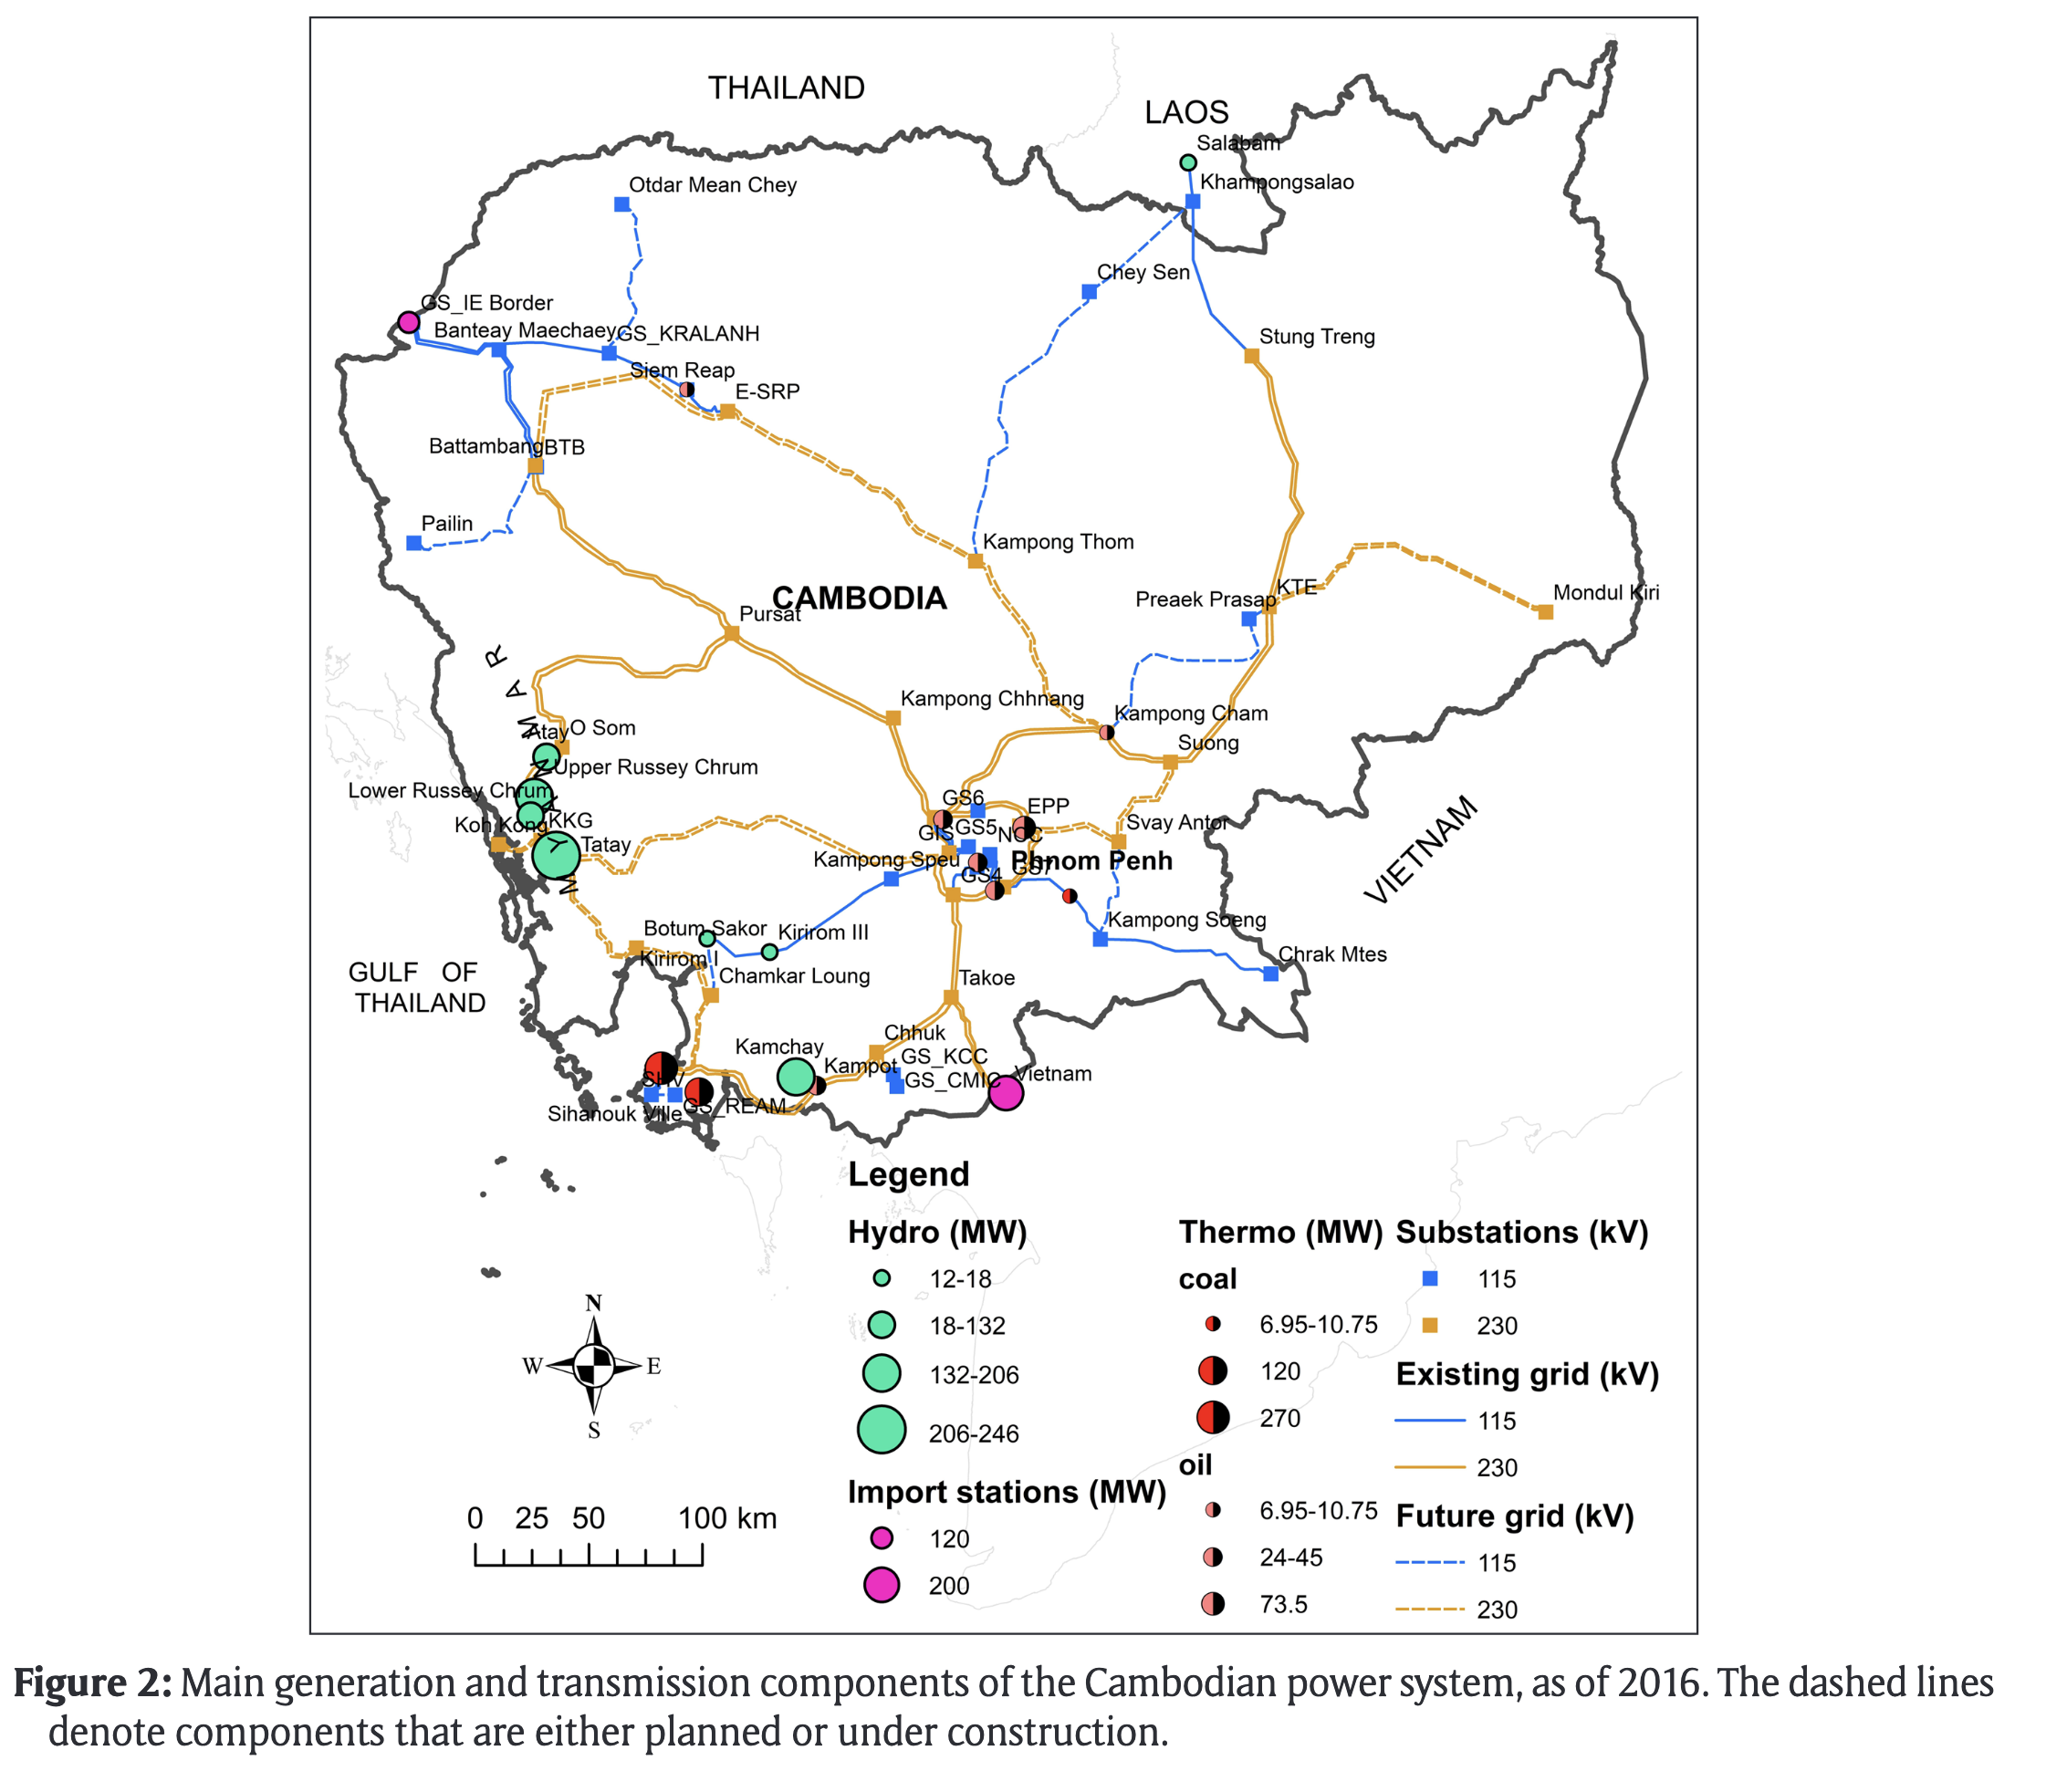 -->
<div>
    <center>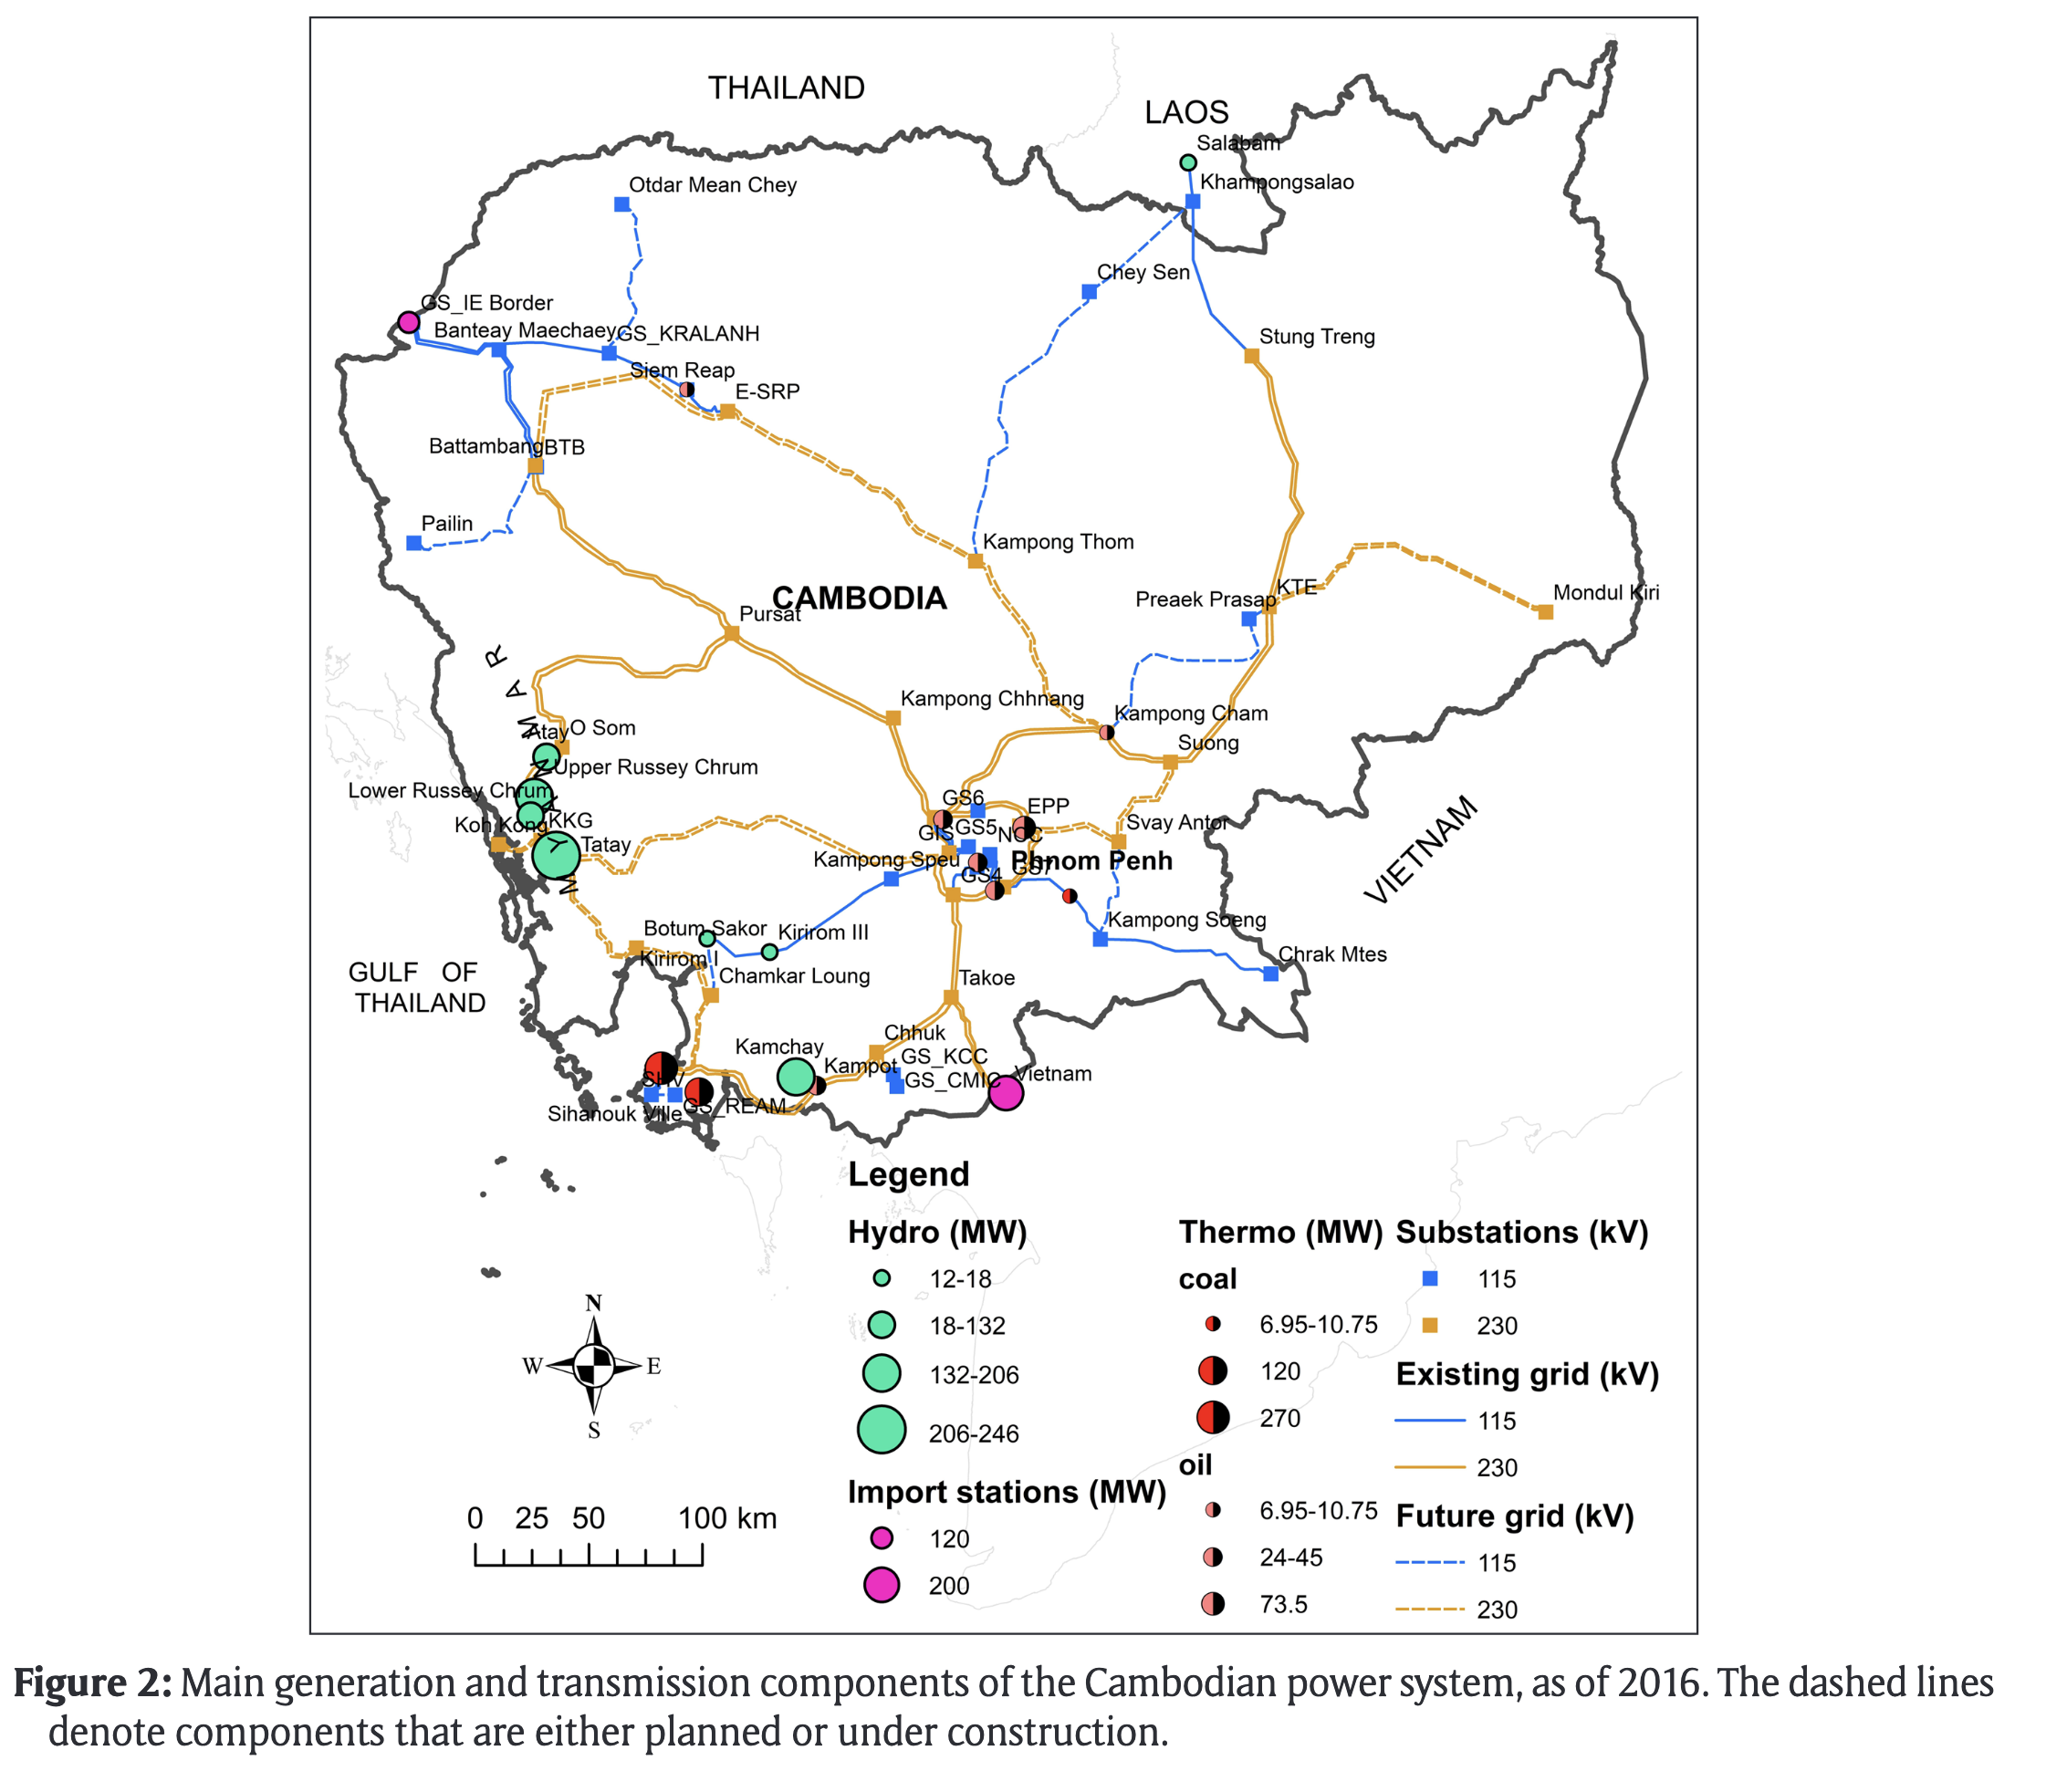</center>
</div>

### Dependencies

In [2]:
using PowerSystems
using PowerSimulations
using PowerAnalytics
using PowerGraphics
using Logging
using Dates
using CSV
using DataFrames
using HiGHS
solver  = optimizer_with_attributes(HiGHS.Optimizer)
plotlyjs()

WebIO._IJuliaInit()

Plots.PlotlyJSBackend()

In [3]:
logger = configure_logging(console_level = Logging.Info,
    file_level = Logging.Debug,
    filename = "log.txt");

# Logging.disable_logging(Logging.Warn)
# sim_folder = mkpath(joinpath(pwd(), "Cambodia-sim"))

### Load the `System` from the serialized data.
<!-- *Note that the underlying time-series data is from 2016; time-stamps list 2017 as a hack from Cambodia-data-prep.jl to accommodate the fact that 2016 is a leap year and we have no leap day information* -->

In [4]:
sys = System("sys-cambodia.json")

[ Info: Loaded time series from storage file existing=sys-cambodia_time_series_storage.h5 new=/var/folders/_t/4yx83vws0ls_k18lgqrg8wrc0000gn/T/jl_aUzmWC compression=CompressionSettings(false, CompressionTypes.DEFLATE = 1, 3, true)


System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ Name              │             │
│ Description       │             │
│ System Units Base │ DEVICE_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 142         │
└───────────────────┴─────────────┘

Static Components
┌───────────────────┬───────┬────────────────────────┬───────────────┐
│ Type              │ Count │ Has Static Time Series │ Has Forecasts │
├───────────────────┼───────┼────────────────────────┼───────────────┤
│ Arc               │ 32    │ false                  │ false         │
│ Area              │ 1     │ false                  │ false         │
│ Bus               │ 30    │ false                  │ false         │
│ HydroDispatch     │ 7     │ true                   │ true          │
│ Line              │ 32    │ false                  │ false         │
│ PowerLoad         │ 15    │ true                   │ true          │
│ RenewableDispatch │ 5     │ true                   │ true          │
│ ThermalStandard   │ 20    │ false                  │ false         │
└───────────────────┴───────┴────────────────────────┴───────────────┘

Time Series Summary
┌──────────────────────────────────┬─────────────────────┐
│ Property                         │ Value               │
├──────────────────────────────────┼─────────────────────┤
│ Components with time series data │ 27                  │
│ Total StaticTimeSeries           │ 27                  │
│ Total Forecasts                  │ 27                  │
│ Resolution                       │ 60 minutes          │
│ First initial time               │ 2017-01-01T00:00:00 │
│ Last initial time                │ 2017-12-30T00:00:00 │
│ Horizon                          │ 48                  │
│ Interval                         │ 1440 minutes        │
│ Forecast window count            │ 364                 │
└──────────────────────────────────┴─────────────────────┘

In [5]:
sys.data.components

Type,Count,Has Static Time Series,Has Forecasts
Arc,32,false,false
Area,1,false,false
Bus,30,false,false
HydroDispatch,7,true,true
Line,32,false,false
PowerLoad,15,true,true
RenewableDispatch,5,true,true
ThermalStandard,20,false,false


## Set up PCM

### Create a problem `template`
Now we can create a `template` that specifies a standard unit commitment problem
with a DCOPF network representation.
Defining the duals allows us to retrieve the LMPs in the results

In [6]:
template = template_unit_commitment(network = NetworkModel(DCPPowerModel, duals = [NodalBalanceActiveConstraint]))

Network Model
┌───────────────┬──────────────────────────────┐
│ Col. 1        │ Col. 2                       │
├───────────────┼──────────────────────────────┤
│ Network Model │ DCPPowerModel                │
│ Slacks        │ false                        │
│ PTDF          │ false                        │
│ Duals         │ NodalBalanceActiveConstraint │
└───────────────┴──────────────────────────────┘

Device Models
┌────────────────────────┬────────────────────────────┬────────┐
│ Device Type            │ Formulation                │ Slacks │
├────────────────────────┼────────────────────────────┼────────┤
│ ThermalStandard        │ ThermalBasicUnitCommitment │ false  │
│ HydroDispatch          │ HydroDispatchRunOfRiver    │ false  │
│ PowerLoad              │ StaticPowerLoad            │ false  │
│ InterruptiblePowerLoad │ PowerLoadInterruption      │ false  │
│ RenewableFix           │ FixedOutput                │ false  │
│ RenewableDispatch      │ RenewableFullDispatch      │ false  │
│ HydroEnergyReservoir   │ HydroDispatchRunOfRiver    │ false  │
└────────────────────────┴────────────────────────────┴────────┘

Branch Models
┌────────────────┬─────────────────┬────────┐
│ Branch Type    │ Formulation     │ Slacks │
├────────────────┼─────────────────┼────────┤
│ Line           │ StaticBranch    │ false  │
│ TapTransformer │ StaticBranch    │ false  │
│ Transformer2W  │ StaticBranch    │ false  │
│ HVDCLine       │ HVDCP2PDispatch │ false  │
└────────────────┴─────────────────┴────────┘

Service Models
┌──────────────────────────────┬──────────────┬────────┬──────────────────┐
│ Service Type                 │ Formulation  │ Slacks │ Aggregated Model │
├──────────────────────────────┼──────────────┼────────┼──────────────────┤
│ VariableReserve{ReserveUp}   │ RangeReserve │ false  │ true             │
│ VariableReserve{ReserveDown} │ RangeReserve │ false  │ true             │
└──────────────────────────────┴──────────────┴────────┴──────────────────┘

### Create a `model`
Now we can apply the `template` to the data (`sys`) to create a `model`.
*Note that you can define multiple models here to create multi-stage simulations*

In [7]:
models = SimulationModels(
    decision_models=[
        DecisionModel(template, sys, optimizer=solver, name="UC"),
    ],
)

Model Name,Model Type,Status,Output Directory
UC,GenericOpProblem,EMPTY,nothing


### Sequential Simulation
In addition to defining the formulation template, sequential simulations require
definitions for how information flows between problems.

In [8]:
DA_sequence = SimulationSequence(
    models=models,
    ini_cond_chronology=InterProblemChronology(),
)

Simulation Sequence
┌──────────────────────────┬──────────┐
│ Col. 1                   │ Col. 2   │
├──────────────────────────┼──────────┤
│ Simulation Step Interval │ 24 hours │
│ Number of Problems       │ 1        │
└──────────────────────────┴──────────┘

Simulation Problems
┌────────────┬─────────┬──────────────┬─────────────────────┐
│ Model Name │ Horizon │ Interval     │ Executions Per Step │
├────────────┼─────────┼──────────────┼─────────────────────┤
│ UC         │ 48      │ 1440 minutes │ 1                   │
└────────────┴─────────┴──────────────┴─────────────────────┘

### Define and build a simulation
This simulation is only 3 days (3 steps) for computation speed. In order to run a year-long (364 days due to the 24 hour lookahead) simulations, the following code is recommended instead:

sim = Simulation(
    name = "Cambodia-year-no_RE",
    steps = 364,
    models=models,
    sequence=DA_sequence,
    simulation_folder=sim_folder,
)

In [9]:
sim = Simulation(
    name = "Cambodia-test",
    steps = 3,
    models=models,
    sequence=DA_sequence,
    simulation_folder=mktempdir(cleanup=true)
)

Simulation
┌─────────────────┬────────────────────┐
│ Col. 1          │ Col. 2             │
├─────────────────┼────────────────────┤
│ Simulation Name │ Cambodia-test      │
│ Build Status    │ EMPTY              │
│ Run Status      │ NOT_READY          │
│ Initial Time    │ Unset Initial Time │
│ Steps           │ 3                  │
└─────────────────┴────────────────────┘

Decision Models
┌────────────┬──────────────────┬────────┬──────────────────┐
│ Model Name │ Model Type       │ Status │ Output Directory │
├────────────┼──────────────────┼────────┼──────────────────┤
│ UC         │ GenericOpProblem │ EMPTY  │ nothing          │
└────────────┴──────────────────┴────────┴──────────────────┘

No Emulator Model Specified

Simulation Sequence
┌──────────────────────────┬──────────┐
│ Col. 1                   │ Col. 2   │
├──────────────────────────┼──────────┤
│ Simulation Step Interval │ 24 hours │
│ Number of Problems       │ 1        │
└──────────────────────────┴──────────┘

Simulation Problems
┌────────────┬─────────┬──────────────┬─────────────────────┐
│ Model Name │ Horizon │ Interval     │ Executions Per Step │
├────────────┼─────────┼──────────────┼─────────────────────┤
│ UC         │ 48      │ 1440 minutes │ 1                   │
└────────────┴─────────┴──────────────┴─────────────────────┘

In [10]:
build!(sim, console_level = Logging.Info, file_level = Logging.Debug,  recorders = [:simulation])

[ Info: Building problem UC
┌ Warning: The system data doesn't include components of type InterruptiblePowerLoad, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type RenewableFix, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type HydroEnergyReservoir, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type TapTransformer, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn

BuildStatus.BUILT = 0

### Execute the simulation

In [11]:
execute!(sim)

┌ Info: Initialize store cache
│   get_min_flush_size(store.cache) = 1048576
└   get_max_size(store.cache) = 1073741824
┌ Info: 
│ ────────────────────────────────────────────────────────────────────────────────────
│                                            Time                    Allocations      
│                                   ───────────────────────   ────────────────────────
│         Tot / % measured:              25.9s / 100.0%           1.03GiB / 100.0%    
│ 
│ Section                   ncalls     time    %tot     avg     alloc    %tot      avg
│ ────────────────────────────────────────────────────────────────────────────────────
│ Execute Simulation             1    25.9s  100.0%   25.9s   1.03GiB  100.0%  1.03GiB
│   Execute UC                   3    24.0s   92.7%   8.01s    807MiB   76.5%   269MiB
│     Solve UC                   3    21.5s   82.8%   7.15s    460MiB   43.6%   153MiB
│     Update State               3    1.66s    6.4%   555ms    183MiB   17.4%  61.1Mi

RunStatus.SUCCESSFUL = 0

## Explore Simulation Results

### Load simulation results

In [12]:
results = SimulationResults(sim)

Decision Problem Results
┌──────────────┬─────────────────────┬──────────────┬─────────────────────────┐
│ Problem Name │ Initial Time        │ Resolution   │ Last Solution Timestamp │
├──────────────┼─────────────────────┼──────────────┼─────────────────────────┤
│ UC           │ 2017-01-01T00:00:00 │ 1440 minutes │ 2017-01-03T00:00:00     │
└──────────────┴─────────────────────┴──────────────┴─────────────────────────┘

Emulator Results
┌─────────────────┬────────────┐
│ Col. 1          │ Col. 2     │
├─────────────────┼────────────┤
│ Name            │ Emulator   │
│ Resolution      │ 60 minutes │
│ Number of steps │ 72         │
└─────────────────┴────────────┘

In [13]:
uc_results = get_decision_problem_results(results, "UC")

Col. 1
EnergyOutput__HydroDispatch
Col. 1
ProductionCostExpression__HydroDispatch
ProductionCostExpression__ThermalStandard
Col. 1
NodalBalanceActiveConstraint__Bus
Col. 1
ActivePowerTimeSeriesParameter__PowerLoad
ActivePowerTimeSeriesParameter__HydroDispatch
Col. 1


### Plot simulation results using [PowerGraphics.jl](https://github.com/nrel-sienna/PowerGrahpics.jl)

In [14]:
plot_fuel(uc_results, generator_mapping_file = "fuel_mapping.yaml");

data: [
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y"
]

layout: "layout with fields barmode, generator, line, linestyle, linewidth, margin, nofill, seriescolor, set, stack, template, title, xaxis, y, and yaxis"

## Read in some summary information about the optimization process
Each objective_value is for the full 48 hour optimization window, including the lookahead

In [15]:
first(read_optimizer_stats(uc_results), 10)

Row,detailed_stats,objective_value,termination_status,primal_status,dual_status,solver_solve_time,result_count,has_values,has_duals,objective_bound,dual_objective_value,solve_time,barrier_iterations,simplex_iterations,node_count,timed_solve_time,timed_calculate_aux_variables,timed_calculate_dual_variables,solve_bytes_alloc,sec_in_gc
,Bool,Float64,Int64,Int64,Int64,Float64,Int64,Bool,Bool,Missing,Missing,Float64,Missing,Missing,Missing,Float64,Float64,Float64,Float64,Float64
1,false,66403.7,1,1,0,NaN,1,false,false,missing,missing,9.35369,missing,missing,missing,9.69357,0.0404018,0.957313,8.28572e7,0.0
2,false,55298.7,1,1,0,NaN,1,false,false,missing,missing,2.13626,missing,missing,missing,2.13758,0.000173583,0.0742891,78208.0,0.0
3,false,62442.5,1,1,0,NaN,1,false,false,missing,missing,7.70414,missing,missing,missing,7.70576,0.0001725,0.0731306,124096.0,0.0


### Now read in the *realized* cost for each timestep for each thermal generator
In this model, wind, solar, and hydro have 0 operating cost and do not contribute to total cost

In [16]:
costs = read_realized_expressions(uc_results, list_expression_names(uc_results))["ProductionCostExpression__ThermalStandard"]

Row,DateTime,CENTRALE-2,CENTRALE-2_CUPL,CENTRALE-3,CENTRALE-5,CENTRALE-6,KAMPONG_CHAM_GTS,KAMPOT_CPP,KEANSVAY,KHAN_DANG_KOR,KHAN_MEAN_CHAY,KHAN_RUSSEY_KEO_COLBEN,PHUM_TROR_CPGC,PPSEZ_PLANT,SIEM_RIEP,SIHANOUKVILLE,SIHANOUKVILLE_CIIDG,SIHANOUKVILLE_COLBEN,SIHANOUKVILLE_STUNG_HAV,impnode_thai,impnode_viet
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2017-01-01T00:00:00,26.1256,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,6.34,33.0948,5.42622e-14,25.36,220.8,-7.69385e-12,0.0
2,2017-01-01T01:00:00,57.06,117.607,48.818,24.5089,58.962,34.0458,28.53,18.4,142.65,152.54,46.916,15.85,31.7,22.0315,12.68,0.0,9.51,220.8,0.0,1.80411e-13
3,2017-01-01T02:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,21.0536,33.0948,0.0,25.36,3.19189e-15,5.86198e-12,0.0
4,2017-01-01T03:00:00,57.06,117.607,31.9901,12.68,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,22.0315,33.0948,0.0,25.36,0.0,0.0,-5.41234e-13
5,2017-01-01T04:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,6.34,22.1314,0.0,9.51,0.0,0.0,-9.02056e-14
6,2017-01-01T05:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,22.0315,33.0948,0.0,21.2121,0.0,0.0,0.0
7,2017-01-01T06:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,22.0315,33.0948,0.0,25.36,444.321,0.0,6.31439e-13
8,2017-01-01T07:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,46.46,142.65,152.54,46.916,15.85,31.7,22.0315,33.0948,496.8,25.36,436.501,0.0,0.0
9,2017-01-01T08:00:00,57.06,117.607,48.818,31.7,58.962,34.0458,76.08,18.4,142.65,152.54,46.916,15.85,31.7,22.0315,33.0948,1005.98,25.36,220.8,-1.1724e-11,0.0


### We can sum over the set of generators and time-steps to get total production cost for this window

In [17]:
sum(sum(eachcol(costs[!, 2:end])))

92974.03390249974

### Look up a table of the Locational Marginal Prices (LMPs)
LMPs represent the value of 1 additional MW of power at the given node
LMPs are reversed in sign

In [18]:
first(read_realized_duals(uc_results)["NodalBalanceActiveConstraint__Bus"], 10)

Row,DateTime,ATYh,BMC,BTB,GS1,GS2,GS3,GS4,GS5,GS6,GS7,IE,KIR1h,KIR3h,KMCh,KPCG,KPCM,KPS,KPT,LRCh,OSM,PRST,SHV,SRP,STH,STR,Salabam,TKO,TTYh,Thai,Viet
,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2017-01-01T00:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
2,2017-01-01T01:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
3,2017-01-01T02:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
4,2017-01-01T03:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
5,2017-01-01T04:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
6,2017-01-01T05:00:00,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0,-317.0
7,2017-01-01T06:00:00,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0
8,2017-01-01T07:00:00,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0
9,2017-01-01T08:00:00,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0,-460.0


# Now, let's connect the potential renewable generators

### Connect renewable generators

In [19]:
for g in get_components(RenewableDispatch, sys)
    set_available!(g, true)
end

### Re-build and re-simulate
If switching to a year-long simulation rather than 3-day snapshot, first re-run the simulation definition. This also saves the result to a separate folder than the "no RE" base case to allow for post-processing comparisons:

sim = Simulation(
    name = "Cambodia-year-RE",
    steps = 364,
    models=models,
    sequence=DA_sequence,
    simulation_folder=sim_folder,
)

In [20]:
build!(sim, console_level = Logging.Info, file_level = Logging.Debug,  recorders = [:simulation]);

[ Info: Building problem UC
┌ Warning: The system data doesn't include components of type InterruptiblePowerLoad, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type RenewableFix, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type HydroEnergyReservoir, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn't include components of type TapTransformer, consider changing the models in the template
└ @ PowerSimulations ~/.julia/packages/PowerSimulations/onHbd/src/operation/operation_model_interface.jl:221
┌ Warning: The system data doesn

In [21]:
execute!(sim);
results_re = SimulationResults(sim);

┌ Info: Initialize store cache
│   get_min_flush_size(store.cache) = 1048576
└   get_max_size(store.cache) = 1073741824
┌ Info: 
│ ────────────────────────────────────────────────────────────────────────────────────
│                                            Time                    Allocations      
│                                   ───────────────────────   ────────────────────────
│         Tot / % measured:              12.3s / 100.0%            230MiB / 100.0%    
│ 
│ Section                   ncalls     time    %tot     avg     alloc    %tot      avg
│ ────────────────────────────────────────────────────────────────────────────────────
│ Execute Simulation             1    12.3s  100.0%   12.3s    230MiB  100.0%   230MiB
│   Execute UC                   3    12.0s   97.4%   4.01s    186MiB   81.0%  62.1MiB
│     Solve UC                   3    11.5s   93.2%   3.83s    108MiB   46.8%  35.9MiB
│     Update State               3    366ms    3.0%   122ms   50.1MiB   21.8%  16.7Mi

In [22]:
uc_results_re = get_decision_problem_results(results_re, "UC")

Col. 1
EnergyOutput__HydroDispatch
Col. 1
ProductionCostExpression__HydroDispatch
ProductionCostExpression__ThermalStandard
ProductionCostExpression__RenewableDispatch
Col. 1
NodalBalanceActiveConstraint__Bus
Col. 1
ActivePowerTimeSeriesParameter__RenewableDispatch
ActivePowerTimeSeriesParameter__PowerLoad


### Plot dispatch stack with renewables

In [23]:
plot_fuel(uc_results_re, generator_mapping_file = "fuel_mapping.yaml");

data: [
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y",
  "scatter with fields fillcolor, line, mode, name, plot, showlegend, stackgroup, type, x, and y"
]

layout: "layout with fields barmode, generator, line, linestyle, linewidth, margin, nofill, seriescolor, set, stack, template, title, xaxis, y, and yaxis"

### Get total operating cost of system with renewables for comparison

In [24]:
costs_re = read_realized_expressions(uc_results_re, list_expression_names(uc_results_re))["ProductionCostExpression__ThermalStandard"]
sum(sum(eachcol(costs_re[!, 2:end])))

64297.26771607633